# Checking if every image has the same resolution

In [1]:
from PIL import Image
import os

def get_resolution(image_path):
    image  = Image.open(image_path)
    return image.size

def check_resoltuion(folder_path):
    image_files = os.listdir(folder_path)
    resolutions = set() # This is a sleazy and easy way to check if all values are the same
    for files in image_files:
        dir = f'{folder_path}/{files}'
        resolution = get_resolution(dir)
        resolutions.add(resolution)
    
    return resolutions
    
resolutions = check_resoltuion('HAM10000_images_part_1')
if len(resolutions) == 1:
    print(f"All images have the same resolution: {resolutions.pop()} pixels.")
else:
    print(f"The images have different resolutions.")
    

All images have the same resolution: (600, 450) pixels.


# Normalize the luminance chanel?

In [6]:
# Separating the luminance channel and adjusting brightness of each image to the same to maintain consistency in like every image
import cv2
import os
import numpy as np

def normalize_color(path):
    image = cv2.imread(path)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # The l is the luminance value. This LAB is another color space like RGB, where L is the luminance, A is I think green and magenta and B is the blue and yellow.
    
    l, a, b = cv2.split(image_lab)
    
    # Apply Equalization Histogram Flatten out all the parts of this channel evenly
    l_eq = cv2.equalizeHist(l)
    print(l_eq)
    image_eq = cv2.merge((l_eq, a, b))
    image_normalized = cv2.cvtColor(image_eq, cv2.COLOR_LAB2BGR)
    images_side_by_side = cv2.hconcat([image, image_normalized])
    cv2.imshow('Original vs Normalized', images_side_by_side)
    cv2.waitKey(0)  
    cv2.destroyAllWindows()

normalize_color('HAM10000_images_part_1/ISIC_0029297.jpg')

[[135 211 176 ...  59  55  59]
 [176 162 162 ...  51  48  44]
 [148 176 176 ...  46  59  51]
 ...
 [ 46  40  39 ...  70  51  55]
 [ 44  37  42 ...  55  46  64]
 [ 44  46  51 ...  55  51  44]]


# Functions for Data Augmentation

C:\Users\adity\AppData\Local\Temp\ipykernel_14936\1816637533.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imageio.imread(url)


ISIC_0024306



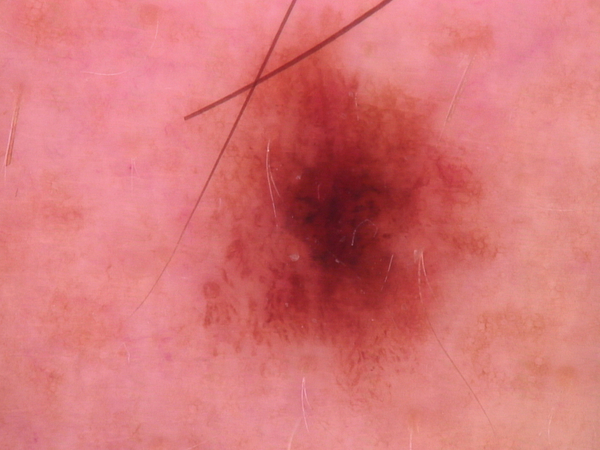
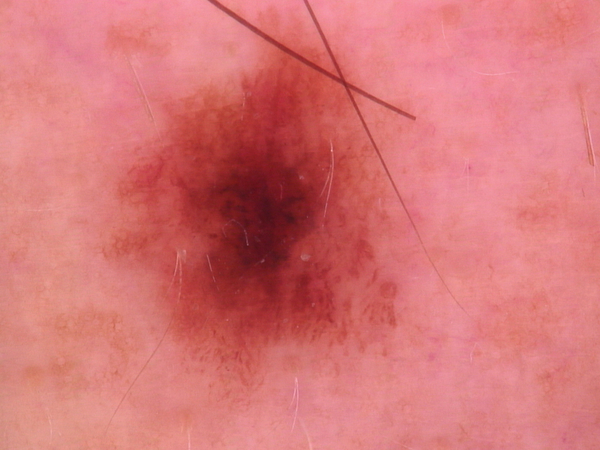
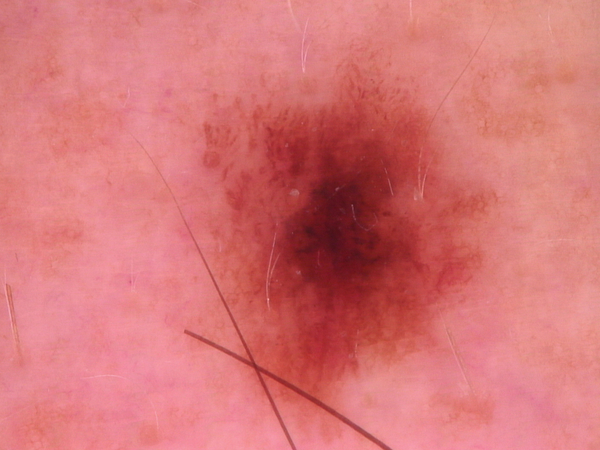
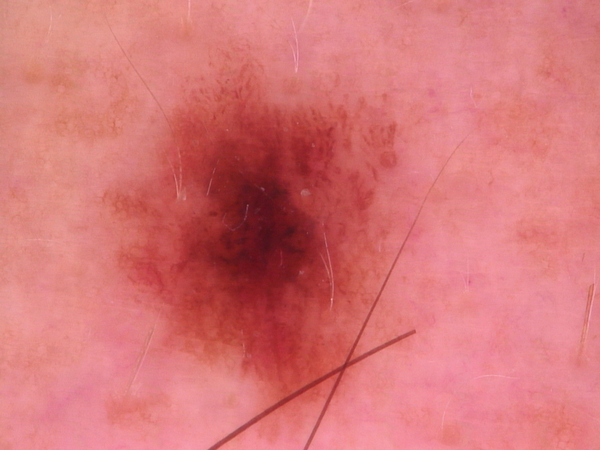
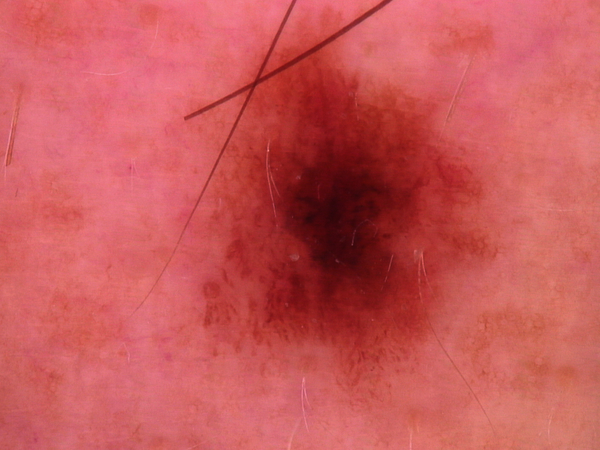


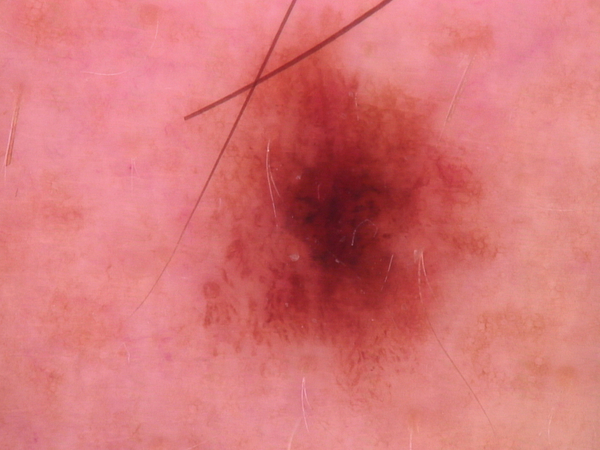
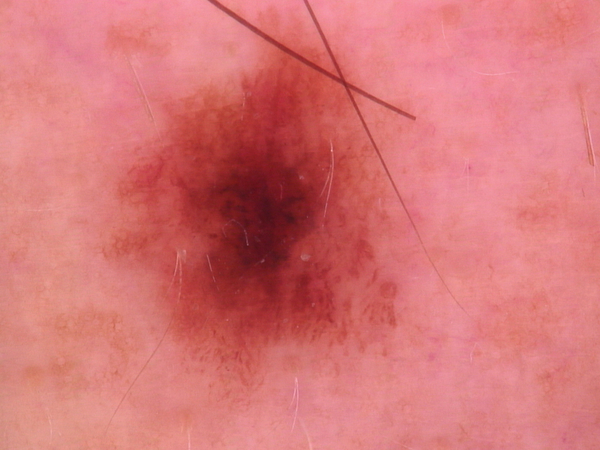
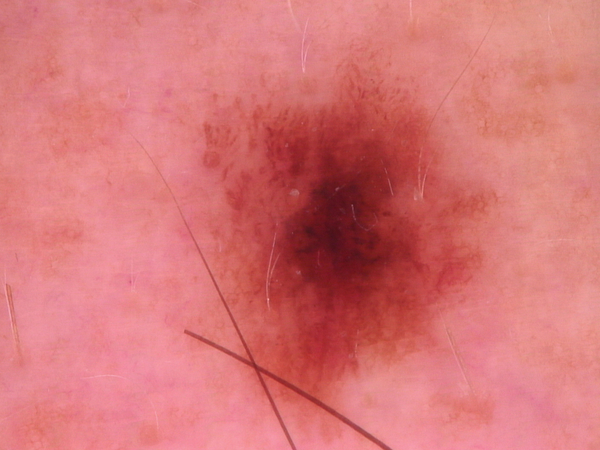
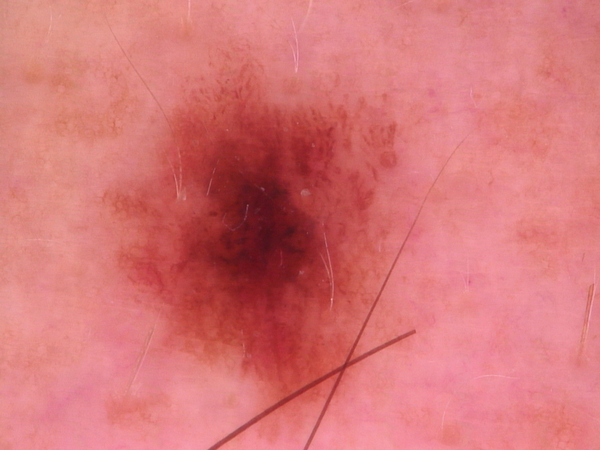
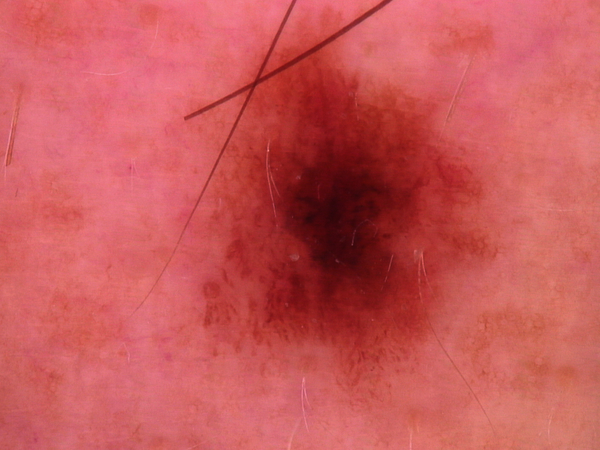

In [2]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot as plt
import os


def horizontal_flip(image, image_id):
    #Initialize the Fliplr
    hflip = iaa.Fliplr(p=1.0)
    input_hf = hflip.augment_image(image)
    new_id = f"{image_id}_hf"
    return input_hf, new_id


def vertical_flip(image, image_id):
    vflip = iaa.Flipud(p = 1.0)
    input_vf = vflip.augment_image(image)
    new_id = f"{image_id}_vf"
    return input_vf, new_id

def rotation(image, image_id):
    #rotating by 180 degrees (very similar to vertical flip)
    img_rotation = iaa.Affine(rotate = 180 )
    input_r = img_rotation.augment_image(image)
    new_id = f"{image_id}_r"
    return input_r, new_id

def contrast(image, image_id):
    img_cont = iaa.GammaContrast(1.4)
    input_cont = img_cont.augment_image(image)
    new_id = f"{image_id}_c"
    return input_cont, new_id

def get_id(filename):
    image_name = os.path.basename(filename)
    image_name, _ = os.path.splitext(image_name)
    return image_name


url = 'HAM10000_images_part_1/ISIC_0024306.jpg'
input_image = imageio.imread(url)
image_id = get_id(url)
print(image_id)

hf, _ = horizontal_flip(input_image, image_id)
vf, _= vertical_flip(input_image,image_id)
rot, _ = rotation(input_image, image_id)
cont, _ = contrast(input_image, image_id)
plt.plot_images([input_image, hf, vf, rot, cont])

# Adding to Metadata

In [4]:
import pandas as pd
from pathlib import Path


metadata_path = 'HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata

def add_to_metadata(metadata, original_id, new_id):
    original_row = metadata[metadata['image_id'] == original_id].copy()
    original_row['image_id'] = new_id
    updated_metadata = metadata.append(original_row, ignore_index=True)
    return updated_metadata


from pathlib import Path

image_dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

for image_dir in image_dirs:
    for image_path in Path(image_dir).glob('*.jpg'):
        input_image = imageio.imread(image_path)
        image_id = image_path.stem 
        hf_image, hf_id = horizontal_flip(input_image, image_id)
        vf_image, vf_id = vertical_flip(input_image, image_id)
        rot_image, rot_id = rotation(input_image, image_id)
        cont_image, cont_id = contrast(input_image, image_id)
        imageio.imwrite(f'{image_dir}/{hf_id}.jpg', hf_image)
        imageio.imwrite(f'{image_dir}/{vf_id}.jpg', vf_image)
        imageio.imwrite(f'{image_dir}/{rot_id}.jpg', rot_image)
        imageio.imwrite(f'{image_dir}/{cont_id}.jpg', cont_image)
        metadata = add_to_metadata(metadata, image_id, hf_id)
        metadata = add_to_metadata(metadata, image_id, vf_id)
        metadata = add_to_metadata(metadata, image_id, rot_id)
        metadata = add_to_metadata(metadata, image_id, cont_id)
        
metadata.to_csv('updated_metadata.csv', index=False)

C:\Users\adity\AppData\Local\Temp\ipykernel_14936\2599007611.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imageio.imread(image_path)


AttributeError: 'DataFrame' object has no attribute 'append'

# Displaying the distribution of diseases to images

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

metadata_path = 'HAM10000_metadata.csv'
data = pd.read_csv(metadata_path)
data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [6]:
import plotly.express as px
ages = data['age']
sexes = data['sex']
dx = data['dx']
skin = data['localization']

fig = px.histogram(data, x='dx', color='dx', title='Distribution of Diagnoses')
fig.show()
fig = px.histogram(data, x='age', title='Age Distribution')
fig.show()
fig = px.histogram(data, x='sex', color='sex', title='Sex Distribution')
fig.show()
fig = px.histogram(data, x='localization', color='localization', title='Localization Distribution')
fig.show()

c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Display an image for each class of the disease

In [7]:
import pandas as pd
import os
import cv2

filtered_images = []
images = dict(data.groupby('dx').first()['image_id'])
print(images)
paths = ['HAM10000_images_part_1','HAM10000_images_part_2']
search = {}

for path in paths:
    files = os.listdir(path)
    for file in files:
        base_name = os.path.splitext(file)[0]
        for dx, image_id in images.items():
            if base_name == image_id:
                search[dx] = os.path.join(path, file)

search

{'akiec': 'ISIC_0029417', 'bcc': 'ISIC_0028155', 'bkl': 'ISIC_0027419', 'df': 'ISIC_0027008', 'mel': 'ISIC_0025964', 'nv': 'ISIC_0024698', 'vasc': 'ISIC_0031197'}


{'nv': 'HAM10000_images_part_1\\ISIC_0024698.jpg',
 'mel': 'HAM10000_images_part_1\\ISIC_0025964.jpg',
 'df': 'HAM10000_images_part_1\\ISIC_0027008.jpg',
 'bkl': 'HAM10000_images_part_1\\ISIC_0027419.jpg',
 'bcc': 'HAM10000_images_part_1\\ISIC_0028155.jpg',
 'akiec': 'HAM10000_images_part_2\\ISIC_0029417.jpg',
 'vasc': 'HAM10000_images_part_2\\ISIC_0031197.jpg'}

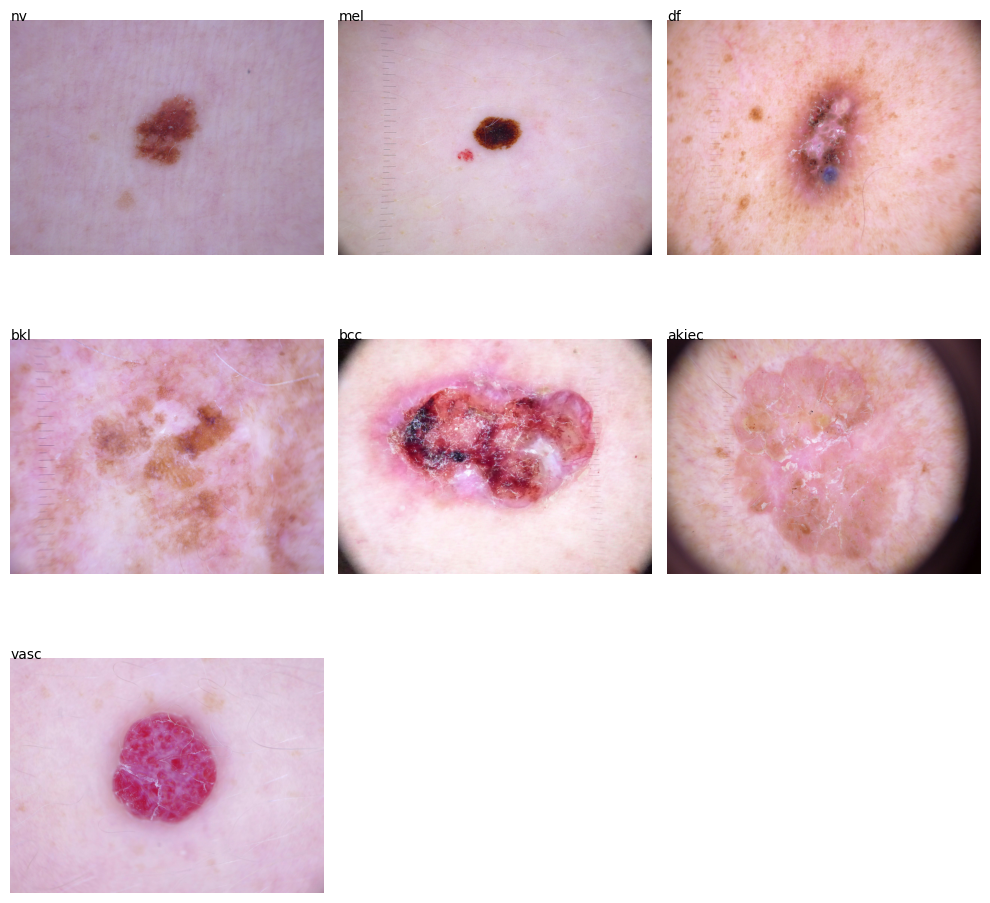

In [8]:
import matplotlib.pyplot as plt
import cv2

n_images = len(search)
grid_size = int(n_images ** 0.5) + 1

plt.figure(figsize=(10, 10))
for i, (dx, image_path) in enumerate(search.items()):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.text(1, 1, dx, fontsize=10)

plt.tight_layout()
plt.show()

# Adding path of image to the dataset

In [10]:
import pandas as pd
import os

metadata_path = 'HAM10000_metadata.csv'
data = pd.read_csv(metadata_path)
paths = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
data['image_path'] = None
for index, row in data.iterrows():
    image_id = row['image_id']
    image_found = False
    for path in paths:
        image_path = os.path.join(path, image_id + '.jpg')
        if os.path.exists(image_path):
            data.at[index, 'image_path'] = image_path
            image_found = True
            break
    if not image_found:
        print(f"Image {image_id} not found in any specified folder.")

print(data.head())
data.to_csv('HAM10000_metadata_paths.csv', index=False)

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                image_path  
0  HAM10000_images_part_1\ISIC_0027419.jpg  
1  HAM10000_images_part_1\ISIC_0025030.jpg  
2  HAM10000_images_part_1\ISIC_0026769.jpg  
3  HAM10000_images_part_1\ISIC_0025661.jpg  
4  HAM10000_images_part_2\ISIC_0031633.jpg  
